In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
from captum.attr import IntegratedGradients
import seaborn as sns

In [3]:
# Hyperparameters
LOOKBACK = 14
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.2

In [4]:
# Load datasets
train_df = pd.read_csv("../data/DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("../data/DailyDelhiClimateTest.csv")

# Preprocess
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])
print("Data loaded and scaled.")
print(train_scaled.shape, test_scaled.shape)

Data loaded and scaled.
(1462, 4) (114, 4)


In [5]:
# Function to create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i][0])  # meantemp
    return np.array(X), np.array(y)

X_train_all, y_train_all = create_sequences(train_scaled, LOOKBACK)
X_test, y_test = create_sequences(test_scaled, LOOKBACK)

In [6]:
# LSTM Model
class LSTMModel(nn.Module):
    # def __init__(self, input_size, hidden_size=50):
    def __init__(self, input_size, hidden_size=128, num_layers=2):  # increased hidden_size and num_layers
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # last time step
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = LSTMModel(input_size=4).to(device)
model = LSTMModel(input_size=4, hidden_size=128, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [32]:
# filepath: d:\Dropbox\Fraunhofer\MA_copy\climate\code\climate_train_new.ipynb
model.load_state_dict(torch.load("../result/lstm_weather_model.pth"))
model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


LSTMModel(
  (lstm): LSTM(4, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

SHAP feature names: ['t-1_meantemp', 't-1_humidity', 't-1_wind_speed', 't-1_meanpressure', 't-2_meantemp', 't-2_humidity', 't-2_wind_speed', 't-2_meanpressure', 't-3_meantemp', 't-3_humidity', 't-3_wind_speed', 't-3_meanpressure', 't-4_meantemp', 't-4_humidity', 't-4_wind_speed', 't-4_meanpressure', 't-5_meantemp', 't-5_humidity', 't-5_wind_speed', 't-5_meanpressure', 't-6_meantemp', 't-6_humidity', 't-6_wind_speed', 't-6_meanpressure', 't-7_meantemp', 't-7_humidity', 't-7_wind_speed', 't-7_meanpressure', 't-8_meantemp', 't-8_humidity', 't-8_wind_speed', 't-8_meanpressure', 't-9_meantemp', 't-9_humidity', 't-9_wind_speed', 't-9_meanpressure', 't-10_meantemp', 't-10_humidity', 't-10_wind_speed', 't-10_meanpressure', 't-11_meantemp', 't-11_humidity', 't-11_wind_speed', 't-11_meanpressure', 't-12_meantemp', 't-12_humidity', 't-12_wind_speed', 't-12_meanpressure', 't-13_meantemp', 't-13_humidity', 't-13_wind_speed', 't-13_meanpressure', 't-14_meantemp', 't-14_humidity', 't-14_wind_speed', 

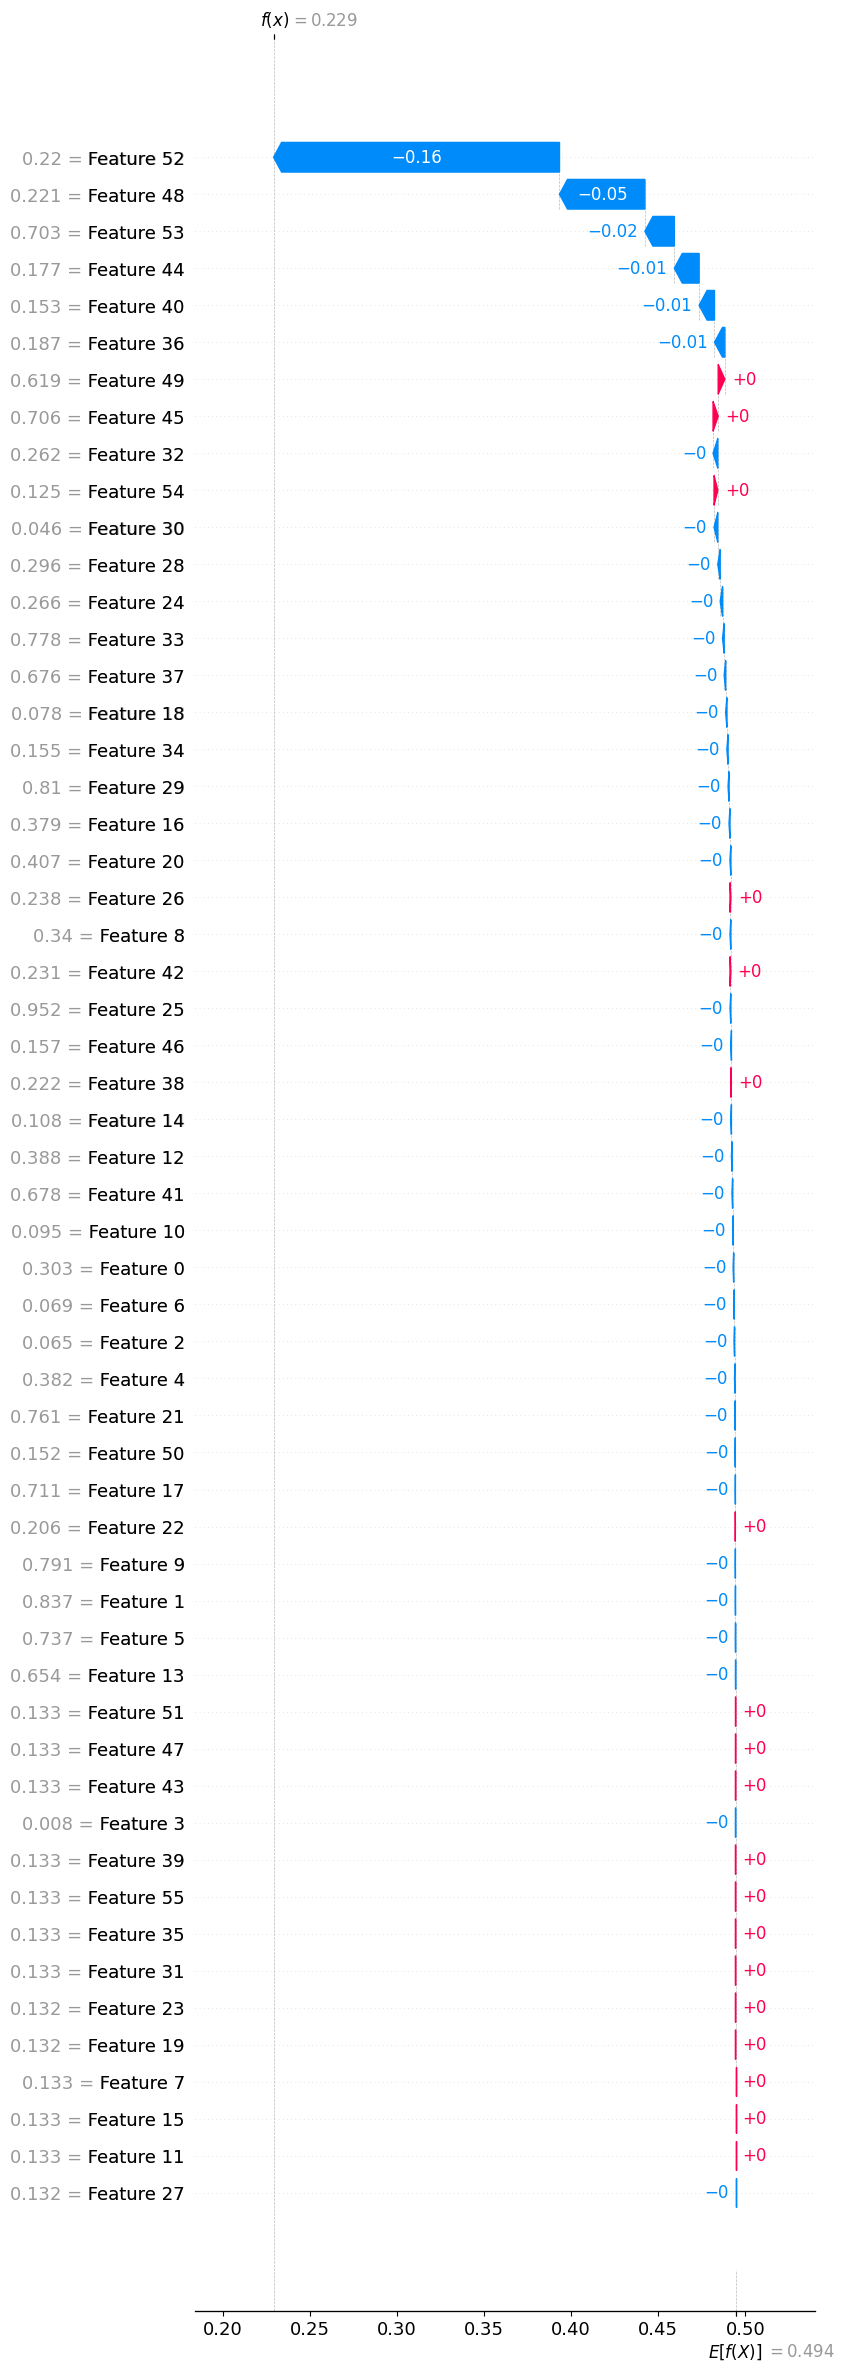

PermutationExplainer explainer: 101it [00:14,  2.23it/s]                         


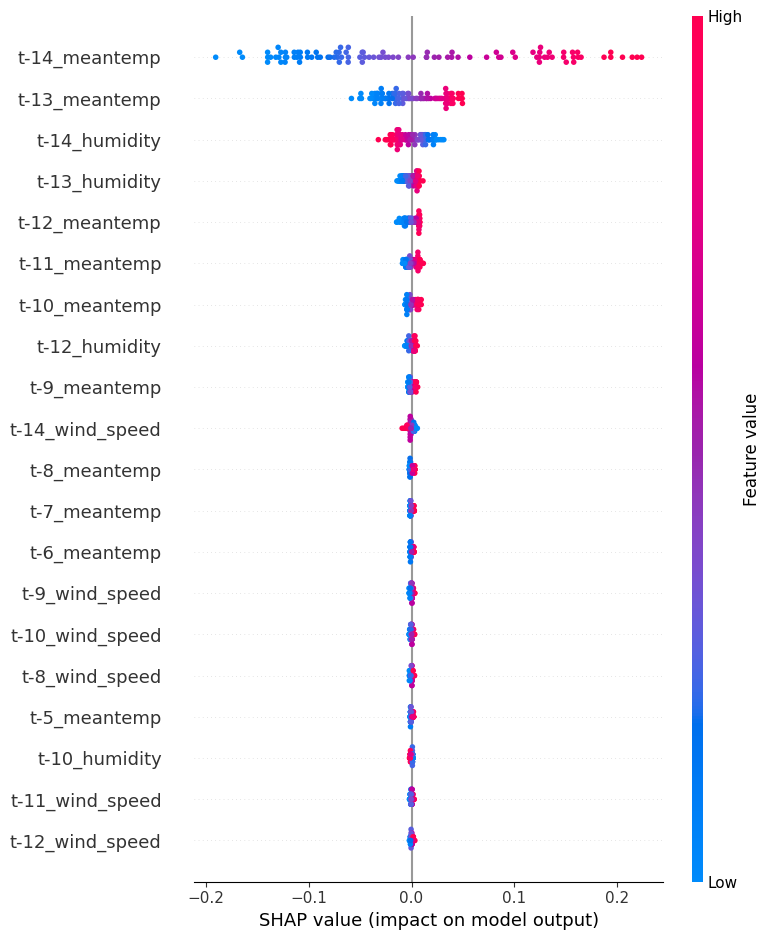

In [ ]:
# SHAP Explanation
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Wrap model for SHAP (expects 2D input)
def model_predict(x):
    x = torch.tensor(x, dtype=torch.float32).view(-1, LOOKBACK, 4).to(device)
    with torch.no_grad():
        return model(x).cpu().numpy()

# SHAP feature names for 14*4 input
shap_feature_names = [f"t-{i//4+1}_{features[i%4]}" for i in range(LOOKBACK * 4)]
print("SHAP feature names:", shap_feature_names)

# SHAP explainer
explainer = shap.Explainer(model_predict, X_test[:100].reshape(100, -1))

# One sample explanation
shap_values_single = explainer(X_test[0].reshape(1, -1))
shap_values_single[0].feature_names = shap_feature_names  # override default feature names
shap_values_single[0].display_data = X_test[0].reshape(1, -1)  # make sure input values are shown correctly
shap.plots.waterfall(shap_values_single[0], max_display=14*4)

# Batch explanation (first 100 samples)
shap_values_batch = explainer(X_test[:100].reshape(100, -1))
shap.summary_plot(shap_values_batch, X_test[:100].reshape(100, -1), feature_names=shap_feature_names)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future

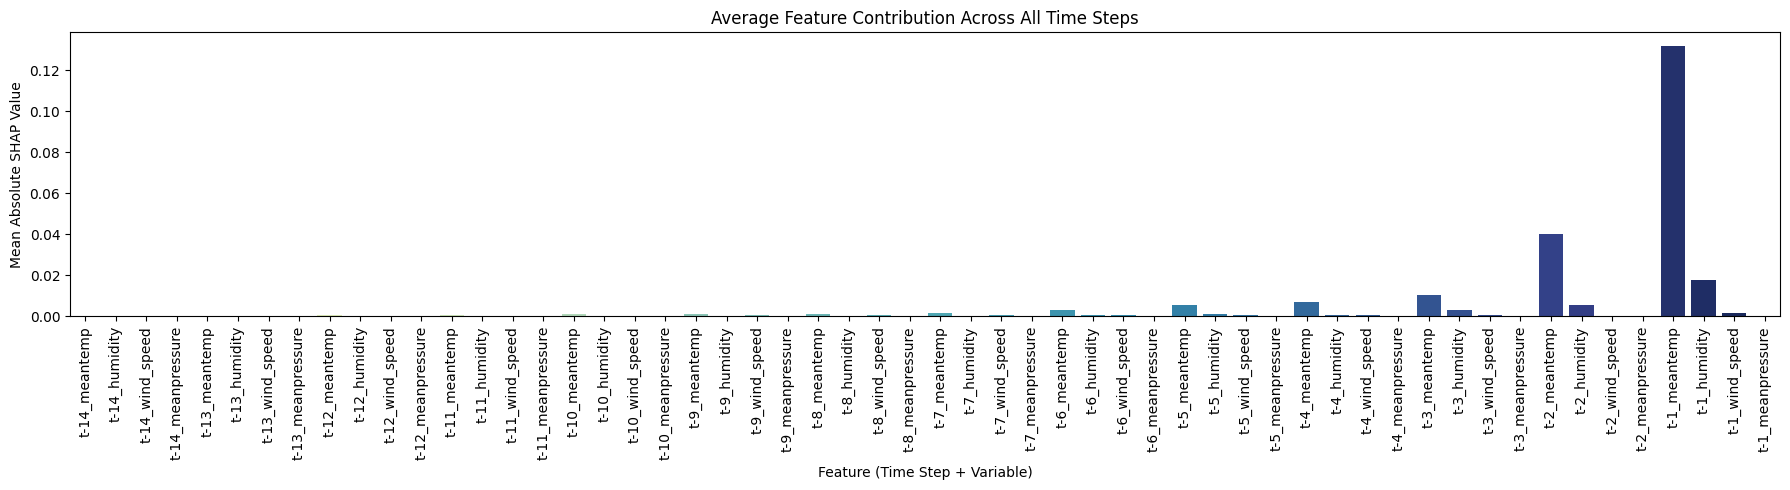

In [ ]:
detailed_feature_names = [f"t-{LOOKBACK-i}_{feat}" for i in range(LOOKBACK) for feat in features]

# mean_abs_vals 形状是 (LOOKBACK, 4)，flatten后和detailed_feature_names一一对应
plt.figure(figsize=(18, 5))
# sns.barplot(x=detailed_feature_names, y=mean_abs_vals.flatten(), palette="Blues_d") # 
sns.barplot(x=detailed_feature_names, y=mean_abs_vals.flatten(), palette="YlGnBu") #
plt.title("Average Feature Contribution Across All Time Steps")
plt.ylabel("Mean Absolute SHAP Value")
plt.xlabel("Feature (Time Step + Variable)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Reshape SHAP values: [samples, LOOKBACK, features]
reshaped = shap_values_batch.values.reshape(-1, LOOKBACK, 4)
mean_abs_vals = np.abs(reshaped).mean(axis=0)  # shape: (LOOKBACK, 4)

# Get max contributing feature and day
day_idx, feat_idx = np.unravel_index(mean_abs_vals.argmax(), mean_abs_vals.shape)
feature_names = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

print(f"Highest contributing feature: {feature_names[feat_idx]} on day t-{LOOKBACK - day_idx}")


Highest contributing feature: meantemp on day t-1


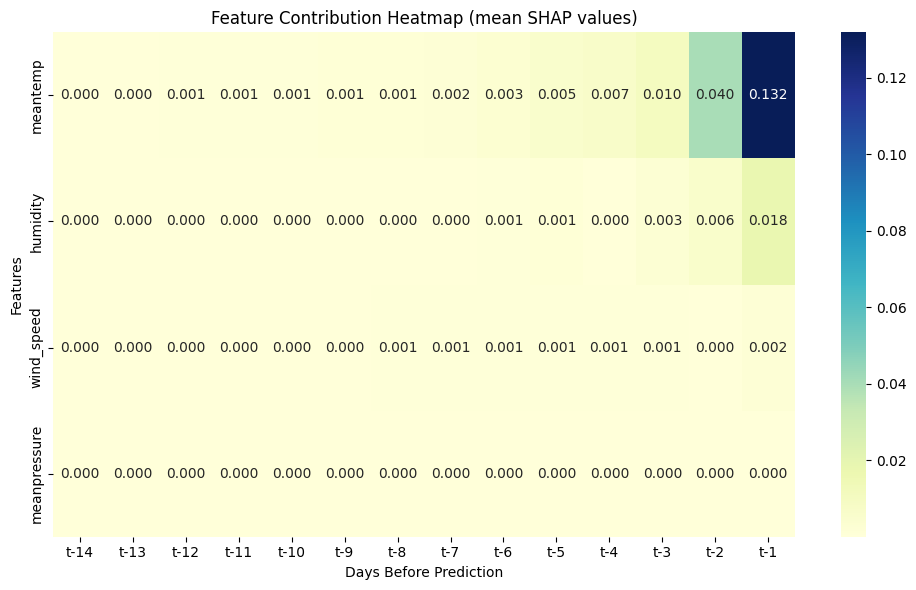

meantemp mean contribution: 0.2049
humidity mean contribution: 0.0297
wind_speed mean contribution: 0.0077
meanpressure mean contribution: 0.0000




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


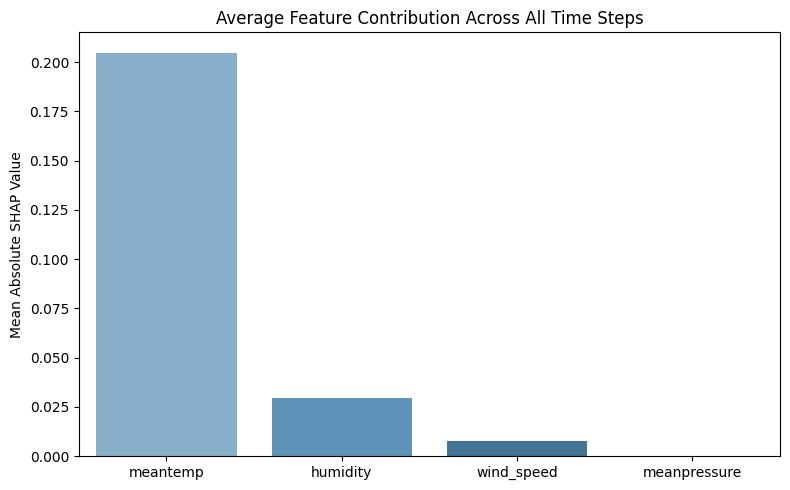

In [ ]:
# Visualize heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mean_abs_vals.T, xticklabels=[f"t-{LOOKBACK-i}" for i in range(LOOKBACK)], yticklabels=features, annot=True, fmt=".3f", cmap="Reds")

plt.title("Feature Contribution Heatmap (mean SHAP values)")
plt.xlabel("Days Before Prediction")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


# Feature ranking across all time steps
feature_importance = np.abs(reshaped).sum(axis=1).mean(axis=0)
for i, val in enumerate(feature_importance):
    print(f"{features[i]} mean contribution: {val:.4f}")

# Plot feature importance as bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=features, y=feature_importance, palette="Blues_d", legend=False)
plt.title("Average Feature Contribution Across All Time Steps")
plt.ylabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.show()

unrecognized nn.Module: LSTM


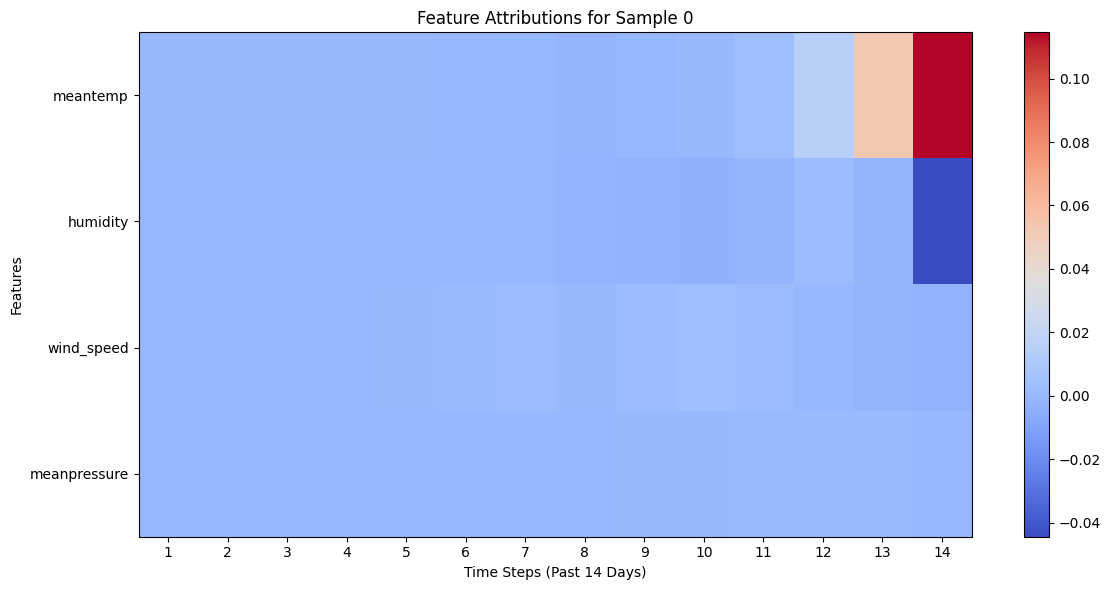

In [16]:
# Make sure your model is in eval mode
# model.eval()

# Enable training mode (needed for CuDNN LSTM backward pass)
model.train()

# Disable dropout manually (set it to eval)
for module in model.modules():
    if isinstance(module, torch.nn.Dropout):
        module.eval()

# Select one or more test inputs to explain
# Example: use the first 10 samples from test set
input_tensor = torch.tensor(X_test[:10], dtype=torch.float32).to(device)

# Use zero baseline (can also use mean of training data)
baseline = torch.zeros_like(input_tensor).to(device)

# Create Integrated Gradients explainer
ig = IntegratedGradients(model)

# Get attributions
attributions, delta = ig.attribute(inputs=input_tensor, baselines=baseline, return_convergence_delta=True)

# Convert to CPU for visualization
attributions = attributions.detach().cpu().numpy()

# Example: visualize attribution for 1st prediction, across 14 time steps and 4 features
sample_idx = 0
plt.figure(figsize=(12, 6))
plt.imshow(attributions[sample_idx].T, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title("Feature Attributions for Sample 0")
plt.xlabel("Time Steps (Past 14 Days)")
plt.ylabel("Features")
plt.xticks(ticks=np.arange(14), labels=np.arange(1, 15))
plt.yticks(ticks=np.arange(4), labels=features)
plt.tight_layout()
plt.show()

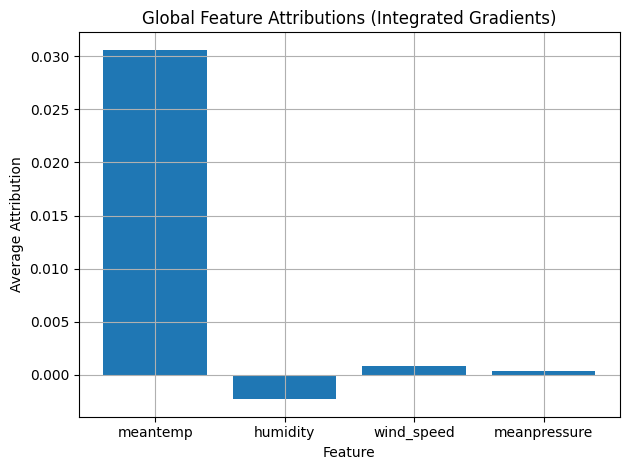

In [19]:
from captum.attr import IntegratedGradients


# Select a batch of test samples
sample_inputs = torch.tensor(X_test[:], dtype=torch.float32).to(device)
baseline = torch.zeros_like(sample_inputs).to(device)

# Enable training mode (needed for CuDNN LSTM backward pass)
model.train()

# Disable dropout manually (set it to eval)
for module in model.modules():
    if isinstance(module, torch.nn.Dropout):
        module.eval()


# # Back to eval mode
# model.eval()

# Integrated Gradients
ig = IntegratedGradients(model)
attributions, _ = ig.attribute(inputs=sample_inputs, baselines=baseline, return_convergence_delta=True)


model.eval()

# Convert to numpy
attributions_np = attributions.detach().cpu().numpy()

# Global attribution: average over samples and time
# Result shape: (features,)
global_attr = attributions_np.mean(axis=0).mean(axis=0)

# Plot global attribution
import matplotlib.pyplot as plt
plt.bar(features, global_attr)
plt.title("Global Feature Attributions (Integrated Gradients)")
plt.ylabel("Average Attribution")
plt.xlabel("Feature")
plt.tight_layout()
plt.grid(True)
plt.show()
